In [2]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
import math
import scipy.stats as scs
from scipy import special, sparse
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs:100

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))   #50,50
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [6]:
# -------- Insert your code here -------- #
Ndrivers = len(rho)

# Generating Scenarios

# -------- Insert your code here -------- #

y = np.zeros((Nout,Ndrivers)) # Systemic risk factors for each out-of-sample scenario
Losses_out = np.zeros((Nout,K)) # Losses for each scenario and each counterparty

for s in range(1,Nout+1):
    # -------- Insert your code here -------- #
    # Generate a normally distributed random vector for systemic risk factors
    normal_random_vector = np.random.randn(Ndrivers,1)
    # Apply the Cholesky decomposition of the correlation matrix to the random vector
    # This introduces the desired correlations among the systemic risk factors
    y[s-1,:] = np.dot(sqrt_rho,normal_random_vector).T

    # Generate idiosyncratic risk factors for each counterparty, assuming normal distribution
    z = np.random.randn(K,1)

    for k in range(1,K+1):
        # Get the credit driver index for the current counterparty
        cd = int(driver[k-1])-1
        # Calculate the creditworthiness index (w) combining systemic and idiosyncratic risk factors
        # This reflects the influence of both market-wide and specific risks on the counterparty
        w = beta[k-1] * y[s-1,cd] + np.sqrt(1 - beta[k-1]**2) * z[k-1]
        # Append the calculated creditworthiness index to the credit state boundaries
        # and sort the array to determine the position of w among the boundaries
        temp = np.append(w,CS_Bdry[k-1,:])
        temp = sorted(temp)
        # Find the index of the calculated creditworthiness index within the sorted array
        # This index corresponds to the credit state of the counterparty
        cs_index = np.argwhere(temp == w)
        # Use the credit state index to determine the loss for the counterparty in the current scenario
        # and store it in the Losses_out matrix
        Losses_out[s-1,k-1] = exposure[k-1,cs_index]

<ipython-input-6-58a16a63f72d>:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Losses_out[s-1,k-1] = exposure[k-1,cs_index]


In [7]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # Portfolio 1: Weights based on value proportion
w0.append(np.ones((K)) / K)  # Portfolio 2: Equally weighted
# Calculate the number of asset units for each portfolio strategy
x0 = []
x0.append((portf_v / value) * w0[0])  # Portfolio 1: Number of units for value-weighted assets
x0.append((portf_v / value) * w0[1])  # Portfolio 2: Number of units for equally-weighted assets

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        # Sort the projected portfolio losses for the current weighting strategy
        Losses = sorted(np.dot(Losses_out,x0[portN]))
        # Calculate out-of-sample VaR at the specified quantile
        VaRout[portN, q] = Losses[int(math.ceil(Nout * alf)) -1]
        # Calculate in-sample VaR using the Normal approximation
        VaRinN[portN, q] = np.mean(Losses) + scs.norm.ppf(alf) * np.std(Losses)
        # Calculate out-of-sample CVaR at the specified quantile
        CVaRout[portN, q] = (1 / (Nout*(1-alf))) * ((math.ceil(Nout*alf)-Nout*alf) * VaRout[portN,q] + sum(Losses[int(math.ceil(Nout*alf)):]))
        # Calculate in-sample CVaR using the Normal approximation
        CVaRinN[portN, q] = np.mean(Losses) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * np.std(Losses)

In [8]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}


for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    # Initialize matrices for systemic risk factors (y_inMC1) and losses (Losses_inMC1)
    y_inMC1 = np.zeros((int(np.ceil(Nin/Ns)),Ndrivers))
    Losses_inMC1 = np.zeros((Nin,K))
    # Generate systemic and idiosyncratic scenarios, calculate losses
    for s in range(1, int(np.ceil(Nin / Ns) + 1)): # systemic scenarios 1000
        # -------- Insert your code here -------- #

        normal_random_vector = np.random.randn(Ndrivers,1)
        y_inMC1[s-1,:] = np.dot(sqrt_rho,normal_random_vector).T

        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic 5
            # -------- Insert your code here -------- #
            z_inMC1 = np.random.randn(K,1)

            # Calculate losses for MC1 approximation (5000 x 100)
            # Losses_inMC1

            for k in range(1,K+1):

                # Identify the credit driver index for the current counterparty
                cd = int(driver[k-1])-1
                # Calculate the creditworthiness index (w) for the current counterparty in the current scenario
                # The formula combines systemic (y_inMC1) and idiosyncratic (z_inMC1) risk factors
                # Systemic risk is weighted by the counterparty's beta, and idiosyncratic risk is adjusted for beta
                w_inMC1 = beta[k-1] * y_inMC1[s-1,cd] + np.sqrt(1 - beta[k-1]**2) * z_inMC1[k-1]
                # Append the creditworthiness index to the credit state boundaries for the current counterparty
                # This creates a combined array that includes the creditworthiness index among the credit state thresholds
                temp_inMC1 = np.append(w_inMC1,CS_Bdry[k-1,:])
                # Sort the combined array to find where the creditworthiness index falls among the credit state thresholds
                temp_inMC1 = sorted(temp_inMC1)
                # Find the index position of the creditworthiness index within the sorted array
                # This index corresponds to the credit state of the counterparty in the current scenario
                cs_index = np.argwhere(temp_inMC1==w_inMC1)
                Losses_inMC1[5*(s-1)+si-1,k-1] = exposure[k-1,cs_index]

    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #

    y_inMC2 = np.zeros((Nin,Ndrivers))
    Losses_inMC2 = np.zeros((Nin,K))

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #

        normal_random_vector = np.random.randn(Ndrivers,1) # Generate random vector for systemic risk
        # Apply the Cholesky decomposition (sqrt_rho) to the random vector
        y_inMC2[s-1,:] = np.dot(sqrt_rho,normal_random_vector).T # Apply correlation to systemic risk
        z_inMC2 = np.random.randn(K,1) # Generate random vector for idiosyncratic risk

    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2

        for k in range(1,K+1):

                cd = int(driver[k-1])-1
                w_inMC2 = beta[k-1] * y_inMC2[s-1,cd] + np.sqrt(1 - beta[k-1]**2) * z_inMC2[k-1]
                temp_inMC2 = np.append(w_inMC2,CS_Bdry[k-1,:])
                temp_inMC2 = sorted(temp_inMC2)
                cs_index = np.argwhere(temp_inMC2==w_inMC2)
                Losses_inMC2[s-1,k-1] = exposure[k-1,cs_index]

    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = sorted(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = sorted(np.dot(Losses_inMC2,x0[portN]))

            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)

            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)

            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)

            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)

            # Compute VaR and CVaR for the current trial
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]

            VaRinN1[portN, q][tr - 1] = mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] = mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2

            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))

            CVaRinN1[portN, q][tr - 1] = mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] = mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC2


<ipython-input-8-81873eb7f26b>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Losses_inMC1[5*(s-1)+si-1,k-1] = exposure[k-1,cs_index]
<ipython-input-8-81873eb7f26b>:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Losses_inMC2[s-1,k-1] = exposure[k-1,cs_index]


In [9]:
# Display VaR and CVaR
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37349930.14, CVaR 99.0% = $44609041.39
In-sample MC1: VaR 99.0% = $37254877.22, CVaR 99.0% = $44998529.94
In-sample MC2: VaR 99.0% = $37343279.89, CVaR 99.0% = $44802906.17
In-sample No: VaR 99.0% = $26143272.82, CVaR 99.0% = $29024433.78
In-sample N1: VaR 99.0% = $26286989.41, CVaR 99.0% = $29186201.98
In-sample N2: VaR 99.0% = $26198217.44, CVaR 99.0% = $29087829.61

Out-of-sample: VaR 99.9% = $53703795.04, CVaR 99.9% = $61660934.98
In-sample MC1: VaR 99.9% = $54417850.76, CVaR 99.9% = $61918734.55
In-sample MC2: VaR 99.9% = $53954556.07, CVaR 99.9% = $60948178.93
In-sample No: VaR 99.9% = $32638087.15, CVaR 99.9% = $34992029.37
In-sample N1: VaR 99.9% = $32822496.31, CVaR 99.9% = $35191186.90
In-sample N2: VaR 99.9% = $32712082.78, CVaR 99.9% = $35072929.73


Portfolio 2:

Out-of-sample: VaR 99.0% = $27413663.21, CVaR 99.0% = $33605625.24
In-sample MC1: VaR 99.0% = $27490547.98, CVaR 99.0% = $33495228.18
In-sample MC2: VaR 99.0% = $27394199

## Plots - Portfolio 1

### Out of Sample True loss distribution (at quantile levels 99%)

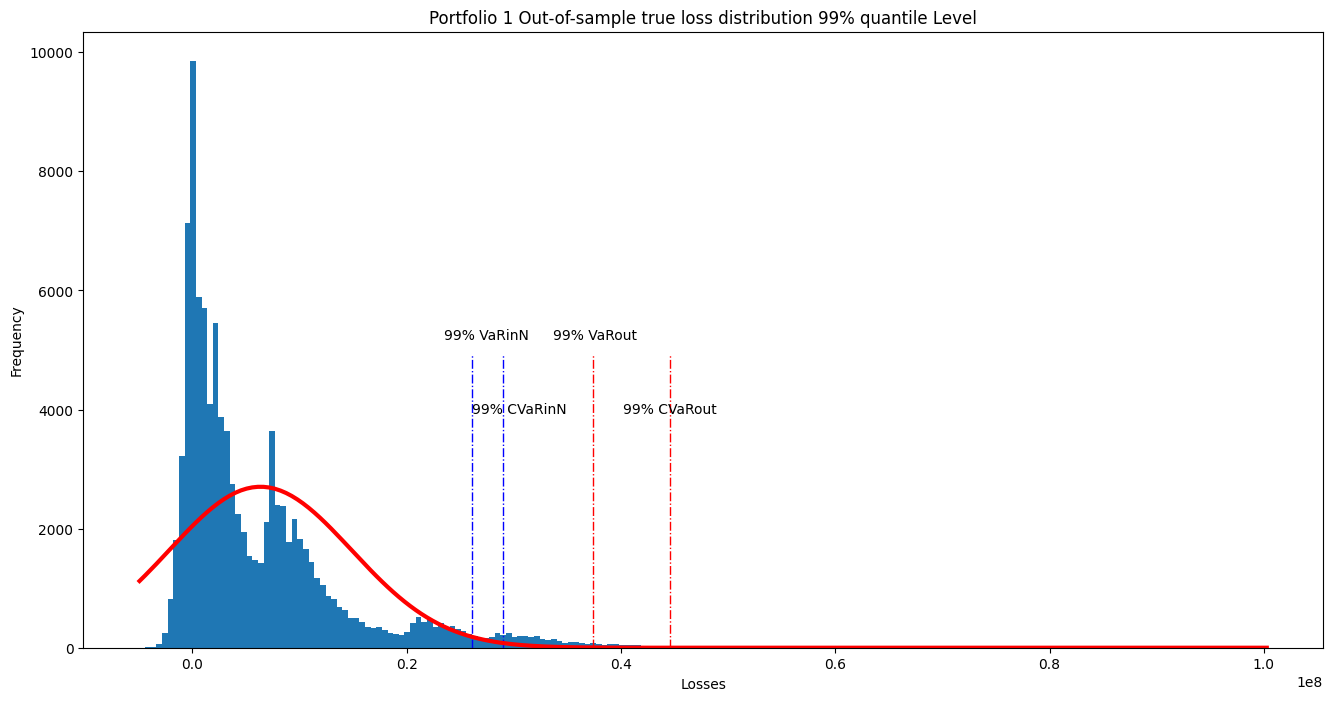

In [22]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 200)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * VaRout[0,0], max(frequencyCounts) / 1.9, '99% VaRout')
plt.text(0.9 * VaRinN[0,0], max(frequencyCounts) / 1.9, '99% VaRinN')
plt.text(0.9 * CVaRout[0,0], max(frequencyCounts) / 2.5, '99% CVaRout')
plt.text(0.9 * CVaRinN[0,0], max(frequencyCounts) / 2.5, '99% CVaRinN')
plt.title('Portfolio 1 Out-of-sample true loss distribution 99% quantile Level')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Out of Sample True loss distribution (at quantile levels 99.9%)

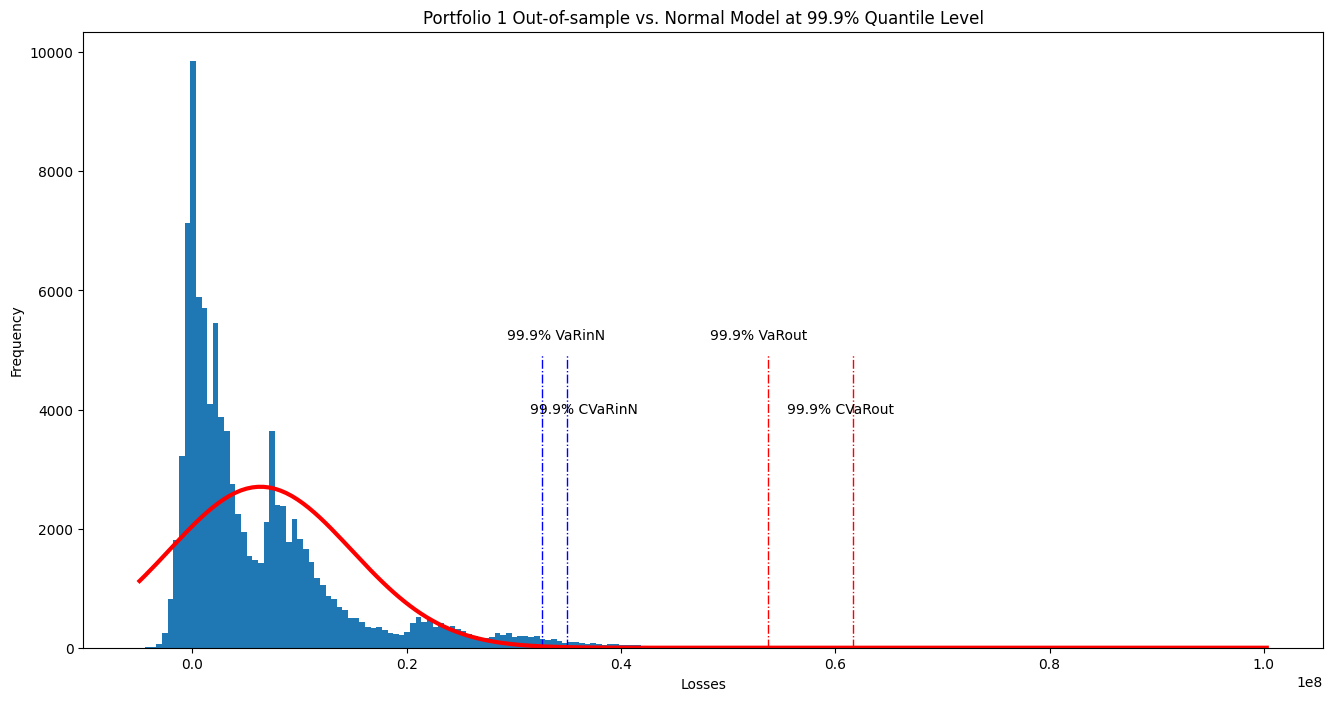

In [23]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 200)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * VaRout[0,1], max(frequencyCounts) / 1.9, '99.9% VaRout')
plt.text(0.9 * VaRinN[0,1], max(frequencyCounts) / 1.9, '99.9% VaRinN')
plt.text(0.9 * CVaRout[0,1], max(frequencyCounts) / 2.5, '99.9% CVaRout')
plt.text(0.9 * CVaRinN[0,1], max(frequencyCounts) / 2.5, '99.9% CVaRinN')
plt.title('Portfolio 1 Out-of-sample true loss distribution 99.9% quantile Level')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Monte Carlo Approximation 1

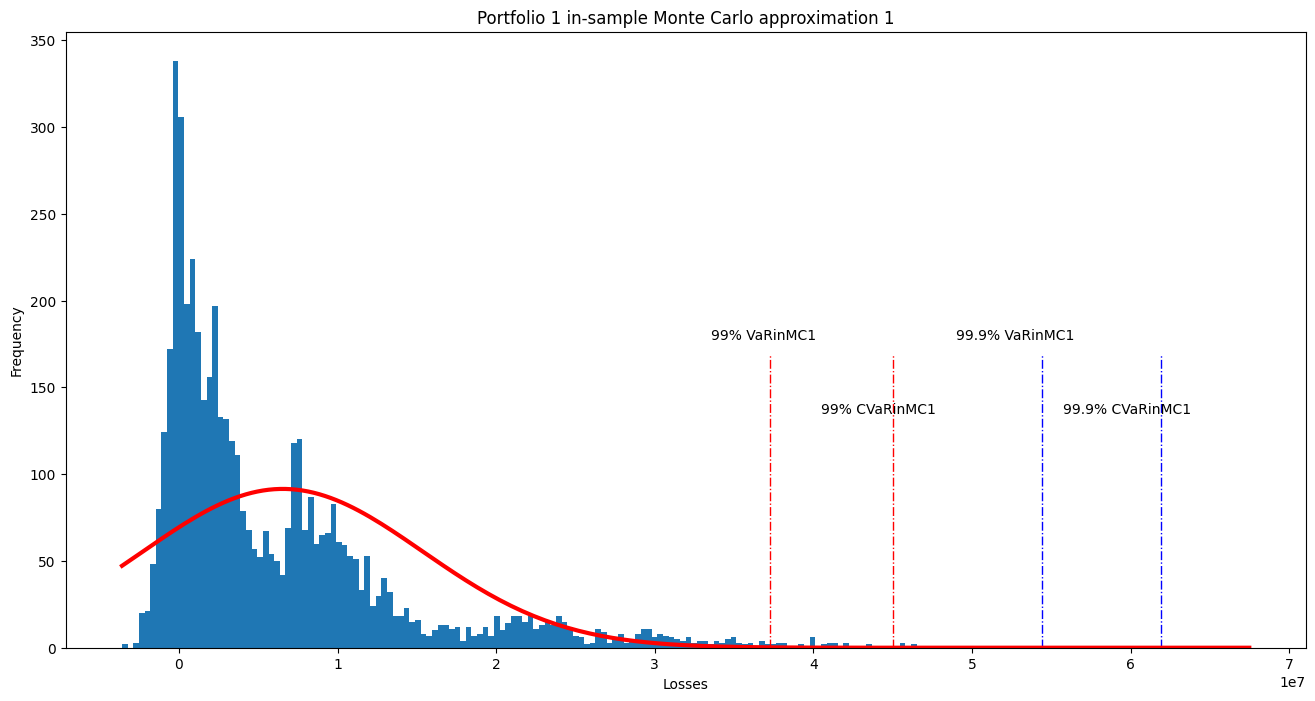

In [77]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[0]), 200)
normf= (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,1]), np.mean(CVaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC1[0,0]), max(frequencyCounts) / 1.9, '99% VaRinMC1')
plt.text(0.9 * np.mean(VaRinMC1[0,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[0,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[0,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC1')
plt.title('Portfolio 1 in-sample Monte Carlo approximation 1')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Monte Carlo Approximation 2

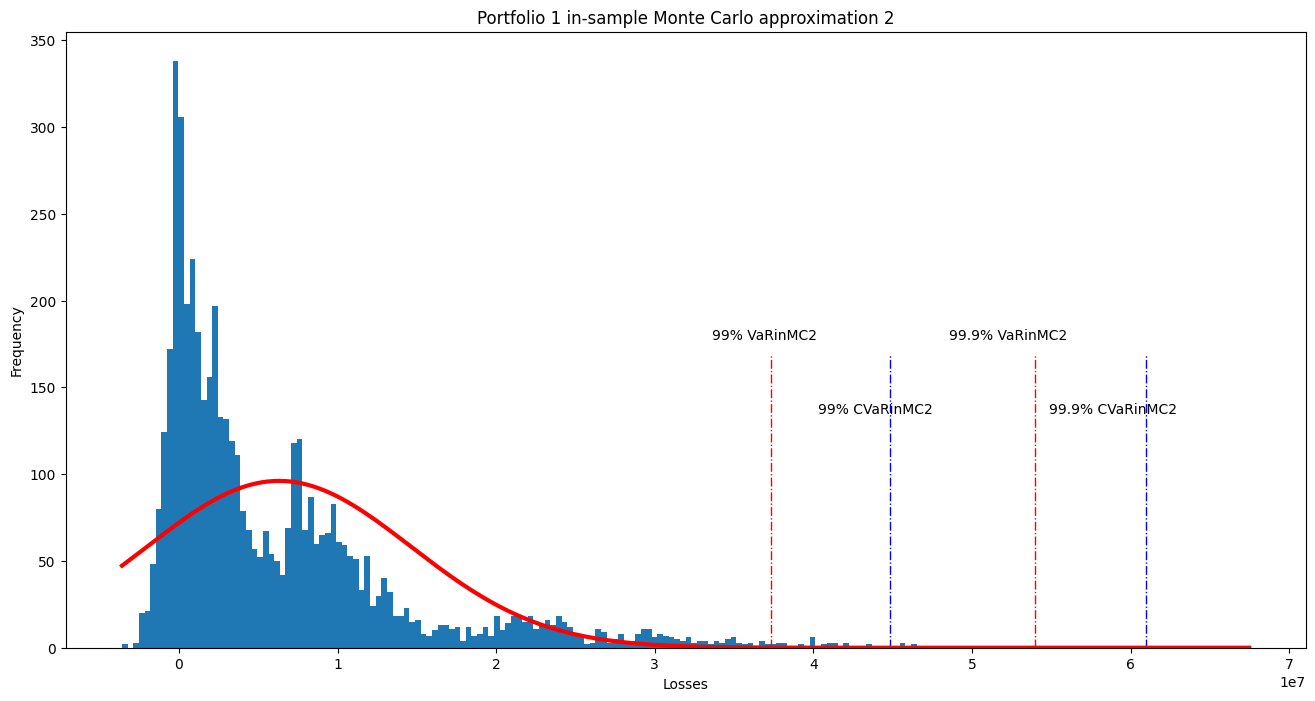

In [78]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[0]), 200)
normf= (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,1]), np.mean(CVaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC2[0,0]), max(frequencyCounts) / 1.9, '99% VaRinMC2')
plt.text(0.9 * np.mean(VaRinMC2[0,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[0,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[0,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC2')
plt.title('Portfolio 1 in-sample Monte Carlo approximation 2')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

## Plots - Portfolio 2

### Out of Sample True loss distribution

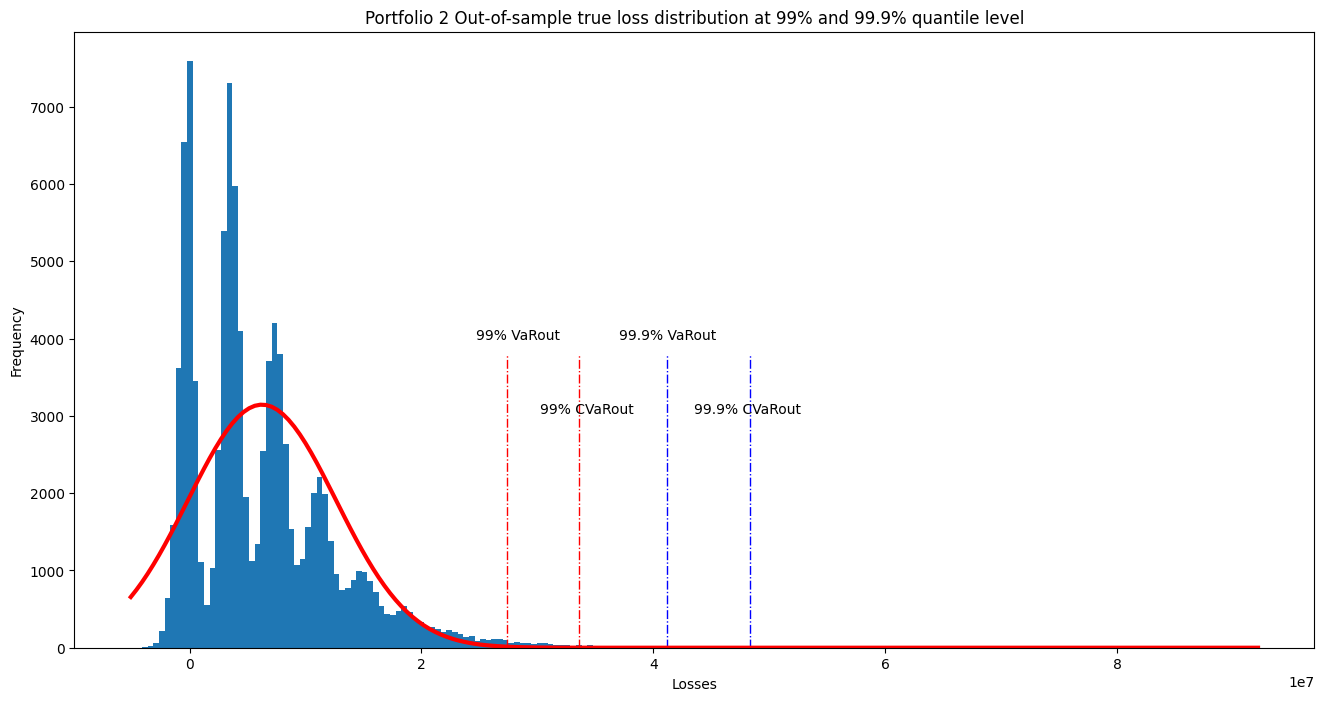

In [34]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[1]), 200)
normf= (1 / (np.std(np.dot(Losses_out,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[1]))) / np.std(np.dot(Losses_out,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * VaRout[1,0], max(frequencyCounts) / 1.9, '99% VaRout')
plt.text(0.9 * VaRout[1,1], max(frequencyCounts) / 1.9, '99.9% VaRout')
plt.text(0.9 * CVaRout[1,0], max(frequencyCounts) / 2.5, '99% CVaRout')
plt.text(0.9 * CVaRout[1,1], max(frequencyCounts) / 2.5, '99.9% CVaRout')
plt.title('Portfolio 2 Out-of-sample true loss distribution at 99% and 99.9% quantile level')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Monte Carlo Approximation 1

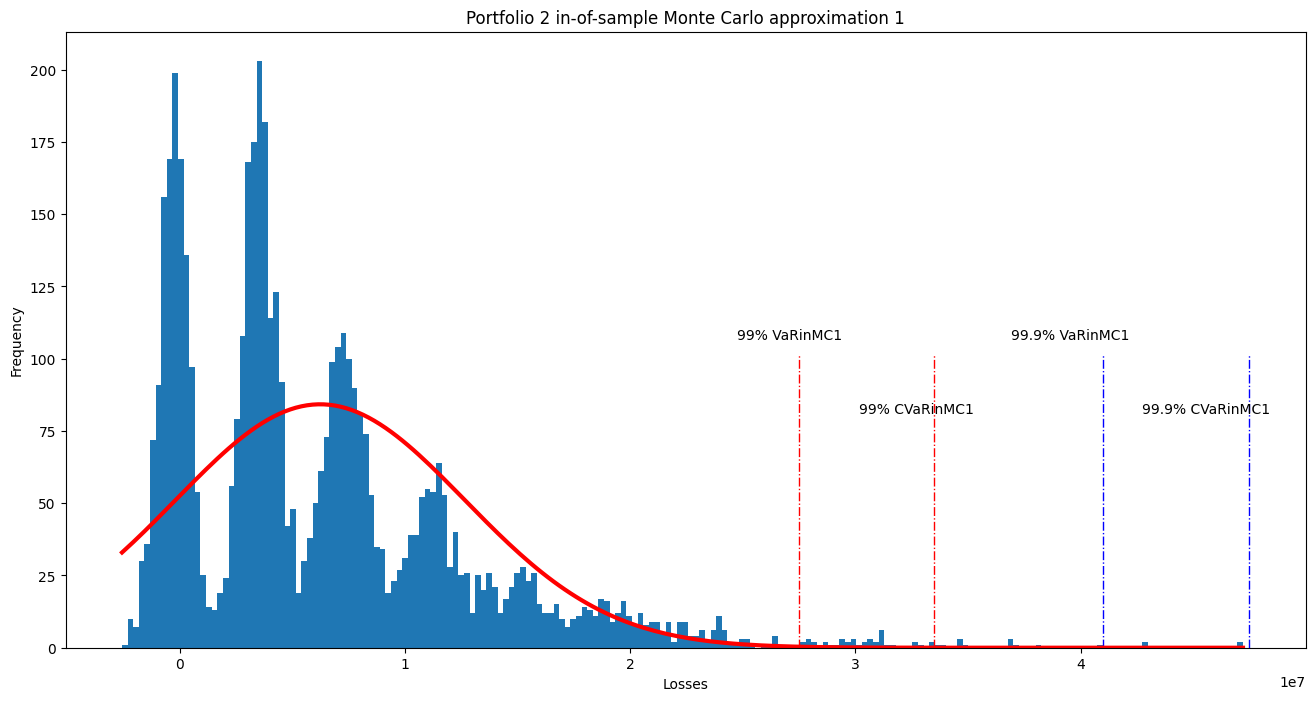

In [28]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC1,x0[1]), 200)

normf= (1 / (np.std(np.dot(Losses_inMC1,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC1,x0[1]))) / np.std(np.dot(Losses_inMC1,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,0]), np.mean(CVaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,1]), np.mean(CVaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC1[1,0]), max(frequencyCounts) / 1.9, '99% VaRinMC1')
plt.text(0.9 * np.mean(VaRinMC1[1,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[1,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[1,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC1')
plt.title('Portfolio 2 in sample Monte Carlo approximation 1')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Monte Carlo Approximation 2

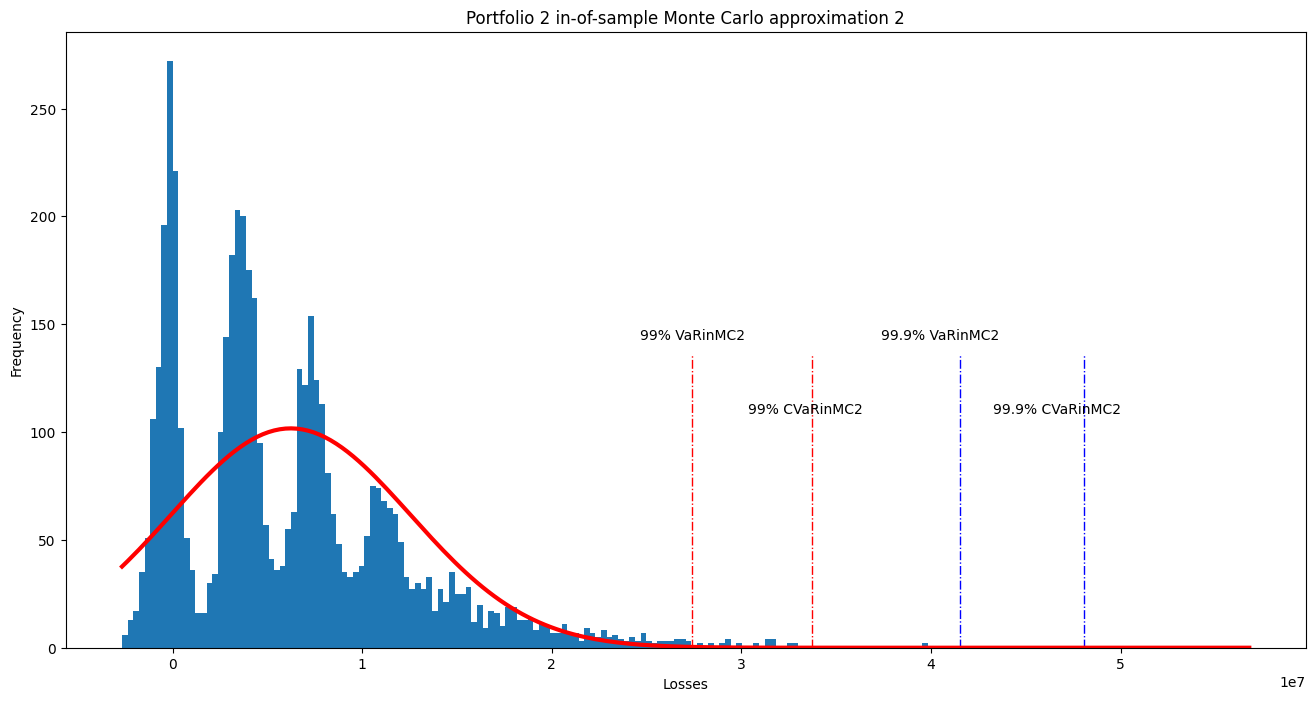

In [29]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[1]), 200)
normf= (1 / (np.std(np.dot(Losses_inMC2,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC2,x0[1]))) / np.std(np.dot(Losses_inMC2,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,0]), np.mean(CVaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,1]), np.mean(CVaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC2[1,0]), max(frequencyCounts) / 1.9, '99% VaRinMC2')
plt.text(0.9 * np.mean(VaRinMC2[1,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[1,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[1,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC2')
plt.title('Portfolio 2 in-sample Monte Carlo approximation 2')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

## Sampling Error and Model Error

In [76]:
# Definitions for the quantile levels
quantile_levels = [0.99, 0.999]

# Define a function to calculate errors
def calculate_errors(true_values, in_sample_values):
    errors = np.abs(true_values - in_sample_values) / true_values
    return np.mean(errors) * 100

# Data structure to hold the results
results = []

# Calculate errors for each quantile level, portfolio, and VaR/CVaR type
for i, alpha in enumerate(quantile_levels):
    for portN in range(2):
        port_label = f"Portfolio {portN+1}"
        alpha_label = f"{int(alpha*100)}%"

        # Model Error
        results.append((f"{alpha_label} VaR, N1, {port_label}", calculate_errors(VaRout[portN, i], VaRinN1[portN, i])))
        results.append((f"{alpha_label} VaR, N2, {port_label}", calculate_errors(VaRout[portN, i], VaRinN2[portN, i])))
        results.append((f"{alpha_label} CVaR, N1, {port_label}", calculate_errors(CVaRout[portN, i], CVaRinN1[portN, i])))
        results.append((f"{alpha_label} CVaR, N2, {port_label}", calculate_errors(CVaRout[portN, i], CVaRinN2[portN, i])))

        # Sampling Error
        results.append((f"{alpha_label} VaR, MC1, {port_label}", calculate_errors(VaRout[portN, i], np.mean(VaRinMC1[portN, i]))))
        results.append((f"{alpha_label} VaR, MC2, {port_label}", calculate_errors(VaRout[portN, i], np.mean(VaRinMC2[portN, i]))))
        results.append((f"{alpha_label} CVaR, MC1, {port_label}", calculate_errors(CVaRout[portN, i], np.mean(CVaRinMC1[portN, i]))))
        results.append((f"{alpha_label} CVaR, MC2, {port_label}", calculate_errors(CVaRout[portN, i], np.mean(CVaRinMC2[portN, i]))))

# Convert results to DataFrame for easier viewing and analysis
error_df = pd.DataFrame(results, columns=['Metric', 'Error (%)'])
error_df.set_index('Metric', inplace=True)

df1 = error_df.iloc[:17]
df2 = error_df.iloc[17:]
# Print the DataFrame
df1,df2


(                            Error (%)
 Metric                               
 99% VaR, N1, Portfolio 1       $29.62
 99% VaR, N2, Portfolio 1       $29.86
 99% CVaR, N1, Portfolio 1      $34.57
 99% CVaR, N2, Portfolio 1      $34.79
 99% VaR, MC1, Portfolio 1       $0.25
 99% VaR, MC2, Portfolio 1       $0.02
 99% CVaR, MC1, Portfolio 1      $0.87
 99% CVaR, MC2, Portfolio 1      $0.43
 99% VaR, N1, Portfolio 2       $22.91
 99% VaR, N2, Portfolio 2       $22.94
 99% CVaR, N1, Portfolio 2      $30.66
 99% CVaR, N2, Portfolio 2      $30.68
 99% VaR, MC1, Portfolio 2       $0.28
 99% VaR, MC2, Portfolio 2       $0.07
 99% CVaR, MC1, Portfolio 2      $0.33
 99% CVaR, MC2, Portfolio 2      $0.33
 99% VaR, N1, Portfolio 1       $38.88,
                             Error (%)
 Metric                               
 99% VaR, N2, Portfolio 1       $39.09
 99% CVaR, N1, Portfolio 1      $42.93
 99% CVaR, N2, Portfolio 1      $43.12
 99% VaR, MC1, Portfolio 1       $1.33
 99% VaR, MC2, Portfolio